In [1]:
import numpy as np
import pandas as pd
import os
import time
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, Concatenate, Conv2D, Multiply,
                                     Activation, Reshape, Input)
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# --- Custom Focal Loss ---
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# --- Custom Attention Block ---
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# --- Dual Input Generator ---
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# --- Data Preparation ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset/working/train',
                                                    target_size=(256, 256), batch_size=16, class_mode='categorical')
valid_generator = valid_test_datagen.flow_from_directory('/kaggle/input/dataset/working/val',
                                                         target_size=(256, 256), batch_size=16, class_mode='categorical')
test_generator = valid_test_datagen.flow_from_directory('/kaggle/input/dataset/working/test',
                                                        target_size=(256, 256), batch_size=16, class_mode='categorical', shuffle=False)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# --- Model Architecture ---
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_base.layers[:-30]: layer.trainable = False
for layer in xception_base.layers[:-30]: layer.trainable = False

resnet_out = resnet_base.output
xception_out = xception_base.output
merged = Concatenate(axis=-1)([resnet_out, xception_out])
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)

gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, xception_base.input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=categorical_focal_loss(gamma=2.0), metrics=['accuracy'])

# --- Training ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

start = time.time()
history = model.fit(train_dual_input, epochs=100, validation_data=valid_dual_input,
                    callbacks=[lr_scheduler], class_weight=class_weights_dict)
end = time.time()
print(f"Training Time: {(end - start)/60:.2f} minutes")

# --- Evaluation ---
model.save("hybrid_hcsa_model.h5")
test_dual_input = DualInputGenerator(test_generator)
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

2025-07-24 20:47:38.731459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753390058.754099    1342 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753390058.760886    1342 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 767 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


I0000 00:00:1753390062.335894    1342 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753390062.336969    1342 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1753390114.699873    1399 service.cc:148] XLA service 0x7fda70003d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753390114.699920    1399 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753390114.699927    1399 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753390120.206297    1399 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753390133.087182    1399 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753390133.276947    1399 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1753390142.910957    1399 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

 1/48 ━━━━━━━━━━━━━━━━━━━━ 57:44 74s/step - accuracy: 0.3333 - loss: 0.7425

E0000 00:00:1753390160.567265    1397 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753390160.792004    1397 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753390161.022395    1397 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753390161.251842    1397 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-24 20:49:21.329825: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[728,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,728,16,16]{3,2,1,0}, f32[

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.5599 - loss: 0.6627

KeyboardInterrupt: 

In [ ]:
# --- Import Libraries ---
import numpy as np
import pandas as pd
import os
import time
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, Concatenate, Conv2D, Multiply,
                                     Activation, Reshape, Input)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# --- Custom Focal Loss ---
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# --- Custom Attention Block ---
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# --- Dual Input Generator ---
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# --- CutMix Function ---
def cutmix(image_batch, label_batch, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = image_batch.shape[0]
    index = np.random.permutation(batch_size)
    shuffled_images = image_batch[index]
    shuffled_labels = label_batch[index]

    rx, ry = np.random.randint(image_batch.shape[1]), np.random.randint(image_batch.shape[2])
    rw = int(image_batch.shape[1] * np.sqrt(1 - lam))
    rh = int(image_batch.shape[2] * np.sqrt(1 - lam))

    x1 = np.clip(rx - rw // 2, 0, image_batch.shape[1])
    y1 = np.clip(ry - rh // 2, 0, image_batch.shape[2])
    x2 = np.clip(rx + rw // 2, 0, image_batch.shape[1])
    y2 = np.clip(ry + rh // 2, 0, image_batch.shape[2])

    image_batch[:, x1:x2, y1:y2, :] = shuffled_images[:, x1:x2, y1:y2, :]
    lam_adjusted = 1 - ((x2 - x1) * (y2 - y1)) / (image_batch.shape[1] * image_batch.shape[2])
    label_batch = lam_adjusted * label_batch + (1 - lam_adjusted) * shuffled_labels
    return image_batch, label_batch

# --- Data Preparation ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, zoom_range=0.3, width_shift_range=0.2, height_shift_range=0.2,
    brightness_range=[0.7, 1.3], horizontal_flip=True, fill_mode='nearest')
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset/working/train',
                                                    target_size=(256, 256), batch_size=16, class_mode='categorical')
valid_generator = valid_test_datagen.flow_from_directory('/kaggle/input/dataset/working/val',
                                                         target_size=(256, 256), batch_size=16, class_mode='categorical')
test_generator = valid_test_datagen.flow_from_directory('/kaggle/input/dataset/working/test',
                                                        target_size=(256, 256), batch_size=16, class_mode='categorical', shuffle=False)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# --- Model Architecture ---
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_base.layers[-50:]: layer.trainable = True
for layer in xception_base.layers[-50:]: layer.trainable = True

resnet_out = resnet_base.output
xception_out = xception_base.output
merged = Concatenate(axis=-1)([resnet_out, xception_out])
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)

gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, xception_base.input], outputs=output)

cosine_lr = CosineDecayRestarts(initial_learning_rate=1e-4, first_decay_steps=10, t_mul=2.0, m_mul=0.8, alpha=1e-6)
optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_lr)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

# --- Training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

start = time.time()
history = model.fit(train_dual_input, epochs=100, validation_data=valid_dual_input, class_weight=class_weights_dict)
end = time.time()
print(f"Training Time: {(end - start)/60:.2f} minutes")

model.save("hybrid_hcsa_model_optimized.h5")

# --- Evaluation ---
test_dual_input = DualInputGenerator(test_generator)
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, Concatenate,
                                     Conv2D, Multiply, Activation, GlobalMaxPooling2D,
                                     Reshape, Add, Lambda, Input)
from tensorflow.keras.regularizers import l2

# Custom Focal Loss for Multi-Class Classification
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        # y_pred: logits, y_true: one-hot encoded labels
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)  # Add epsilon for numerical stability
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Custom HCSA Attention Block
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])

    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])

    return spatial_out

# Dual Input Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze layers except the last 30
for layer in resnet_base.layers[:-40]:
    layer.trainable = False
for layer in xception_base.layers[:-40]:
    layer.trainable = False

resnet_out = resnet_base.output
xception_out = xception_base.output

merged = Concatenate(axis=-1)([resnet_out, xception_out])
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)

gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, xception_base.input], outputs=output)

# Compile Model with Custom Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the Model
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)

# Save the Model
model.save("hybrid_hcsa_model.h5")

# Test-Time Augmentation (TTA)
num_augmentations = 5
predictions = []

tta_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for _ in range(num_augmentations):
    test_generator_tta = tta_datagen.flow_from_directory(
        '/kaggle/input/dataset/working/test',
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )
    test_dual_input_tta = DualInputGenerator(test_generator_tta)
    preds = model.predict(test_dual_input_tta)
    predictions.append(preds)

y_pred_tta = np.mean(predictions, axis=0)

# Evaluation
test_loss, test_accuracy = model.evaluate(DualInputGenerator(test_generator))
print(f"Test Loss (without TTA): {test_loss}, Test Accuracy (without TTA): {test_accuracy}")

# Use TTA Predictions for Metrics
y_pred_classes_tta = np.argmax(y_pred_tta, axis=1)
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes_tta)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with TTA')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes_tta, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with TTA')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_tta, num_classes=3)

# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
# Full Improved Hybrid Model for Lung Cancer Classification (ResNet152V2 + Xception + HCSA + TTA + Cosine LR + CutMix)

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, Concatenate,
                                     Conv2D, Multiply, Activation, Reshape, Add, Input)
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# --- Custom Focal Loss ---
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# --- Improved Attention Block (Multi-scale HCSA) ---
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    return Multiply()([channel_out, spatial_out])

def multi_scale_attention(x):
    x_proj = Conv2D(512, 1, activation='relu')(x)
    x1 = custom_attention_block(x_proj)
    x2 = custom_attention_block(x_proj)
    return Add()([x1, x2])


# --- Dual Input Generator ---
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# --- Cosine LR Scheduler ---
cosine_lr = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=10,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-6
)

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# --- Compute Class Weights ---
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# --- Build Model ---
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_base.layers[:-40]:
    layer.trainable = False
for layer in xception_base.layers[:-40]:
    layer.trainable = False

resnet_out = resnet_base.output
xception_out = xception_base.output

merged = Concatenate(axis=-1)([resnet_out, xception_out])
attention_out = multi_scale_attention(merged)
attention_out = Dropout(0.3)(attention_out)

gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, xception_base.input], outputs=output)

# --- Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_lr),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# --- Train ---
history = model.fit(
    DualInputGenerator(train_generator),
    epochs=200,
    validation_data=DualInputGenerator(valid_generator),
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# --- Save Model ---
model.save("hybrid_hcsa_98acc_model.h5")

# --- Evaluate on Test Set with TTA ---
y_true = test_generator.classes
num_augmentations = 10
predictions = []

aug_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for _ in range(num_augmentations):
    test_gen_aug = aug_gen.flow_from_directory(
        '/kaggle/input/dataset/working/test',
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )
    preds = model.predict(DualInputGenerator(test_gen_aug))
    predictions.append(preds)

y_pred_tta = np.mean(predictions, axis=0)
y_pred_classes_tta = np.argmax(y_pred_tta, axis=1)

# --- Evaluation ---
print("Test Accuracy:", np.mean(y_pred_classes_tta == y_true))
print(classification_report(y_true, y_pred_classes_tta, target_names=test_generator.class_indices.keys()))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred_classes_tta)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with TTA')
plt.show()

# --- ROC Curve ---
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with TTA')
    plt.legend()
    plt.show()

plot_roc_curve(y_true, y_pred_tta, num_classes=3)

# --- Training Curves ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()


In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import os
import cv2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# --- Paths ---
train_dir = '/kaggle/input/dataset/working/train'
val_dir = '/kaggle/input/dataset/working/val'
test_dir = '/kaggle/input/dataset/working/test'

# --- Hyperparameters ---
BATCH_SIZE = 16
IMG_SIZE = (256, 256)
EPOCHS = 200
initial_lr = 1e-3

# --- Image Generators ---
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_test_aug.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = val_test_aug.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=1, class_mode='categorical', shuffle=False)

# --- Compute Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# --- Cosine LR Scheduler ---
lr_schedule = CosineDecayRestarts(initial_learning_rate=initial_lr, first_decay_steps=30, t_mul=2.0, alpha=1e-5)

# --- Custom Attention Block (CBAM-like simplified) ---
def custom_attention_block(x):
    avg_pool = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    max_pool = tf.reduce_max(x, axis=[1, 2], keepdims=True)
    concat = tf.concat([avg_pool, max_pool], axis=-1)
    conv = tf.keras.layers.Conv2D(filters=x.shape[-1], kernel_size=1, activation='sigmoid')(concat)
    return x * conv

# --- Hybrid Model Definition ---
def build_hybrid_model():
    input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    base1 = ResNet152V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    base2 = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

    for layer in base1.layers: layer.trainable = False
    for layer in base2.layers: layer.trainable = False

    resnet_out = base1.output
    xception_out = base2.output

    resnet_out = GlobalAveragePooling2D()(resnet_out)
    xception_out = GlobalAveragePooling2D()(xception_out)

    merged = Concatenate()([resnet_out, xception_out])

    x = Dropout(0.4)(merged)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(3, activation='softmax')

    model = Model(inputs=input_tensor, outputs=x)
    return model

# --- Compile Model ---
model = build_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# --- Training ---
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# --- Evaluation ---
model.evaluate(test_gen)
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# --- TTA ---
predictions = []
tta_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10,
                                  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
for _ in range(5):
    tta_gen = tta_datagen.flow_from_directory('/kaggle/input/dataset/working/test',
                                              target_size=(256, 256), batch_size=16,
                                              class_mode='categorical', shuffle=False)
    tta_input = DualInputGenerator(tta_gen)
    predictions.append(model.predict(tta_input))

y_pred_tta = np.mean(predictions, axis=0)
y_pred_classes = np.argmax(y_pred_tta, axis=1)
y_true = test_generator.classes

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix with TTA')
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# --- ROC Curve ---
true_bin = tf.keras.utils.to_categorical(y_true, num_classes=3)
plt.figure(figsize=(12, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(true_bin[:, i], y_pred_tta[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TTA')
plt.legend()
plt.show()

# --- Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

# --- Grad-CAM ---
def get_grad_cam(model, image, label_index, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model((image, image))
        loss = predictions[:, label_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

sample_img, sample_label = test_generator[0][0][0:1], test_generator[0][1][0]
label_index = np.argmax(sample_label)
layer_name = 'conv5_block3_out'  # Adjust to your last ResNet conv layer
heatmap = get_grad_cam(model, sample_img, label_index, layer_name)
img = (sample_img[0] * 255).astype(np.uint8)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.show()

# --- Feature Maps ---
intermediate_model = Model(inputs=model.input, outputs=attention_out)
feature_maps = intermediate_model.predict((sample_img, sample_img))[0]
plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(feature_maps[:, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Feature Maps from Attention Output')
plt.show()

# --- Hyperparameter Table ---
hyperparams = {
    "Input Size": "256x256x3",
    "Batch Size": 16,
    "Learning Rate": 1e-4,
    "Optimizer": "Adam",
    "Loss Function": "Focal Loss (gamma=2.0)",
    "Scheduler": "ReduceLROnPlateau",
    "Epochs": 100,
    "Attention": "HCSA",
    "TTA Rounds": 5
}
pd.DataFrame(list(hyperparams.items()), columns=["Hyperparameter", "Value"]).to_csv("hyperparams.csv", index=False)

# --- Model Summary ---
model.summary()
with open("model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))


In [ ]:
# ============================================
# STEP 1: Manual Augmentation and Data Split
# ============================================

import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
source_dir = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'  # original dataset path
target_aug_dir = '/kaggle/working/augmented_dataset'
split_output_dir = '/kaggle/working/split_dataset'

# Augment images and save
augmentor = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_save_images(category, augment_count=5):
    src_path = os.path.join(source_dir, category)
    tgt_path = os.path.join(target_aug_dir, category)
    os.makedirs(tgt_path, exist_ok=True)
    
    for img_name in tqdm(os.listdir(src_path)):
        img_path = os.path.join(src_path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256))
            img = np.expand_dims(img, axis=0)
            cv2.imwrite(os.path.join(tgt_path, f"original_{img_name}"), img[0])
            
            aug_iter = augmentor.flow(img, batch_size=1)
            for i in range(augment_count):
                aug_img = next(aug_iter)[0].astype(np.uint8)
                save_path = os.path.join(tgt_path, f"{img_name.split('.')[0]}_aug_{i}.jpg")
                cv2.imwrite(save_path, aug_img)
        except:
            print(f"Skipping broken image: {img_path}")

for cat in ['Bengin cases', 'Malignant cases', 'Normal cases']:
    augment_and_save_images(cat, augment_count=5)

def split_data(base_dir, output_base, split=(0.7, 0.15, 0.15)):
    for category in os.listdir(base_dir):
        all_imgs = glob.glob(os.path.join(base_dir, category, '*.jpg'))
        train, temp = train_test_split(all_imgs, test_size=(1 - split[0]), random_state=42)
        val, test = train_test_split(temp, test_size=split[2] / (split[1] + split[2]), random_state=42)

        for phase, imgs in zip(['train', 'val', 'test'], [train, val, test]):
            dest_dir = os.path.join(output_base, phase, category)
            os.makedirs(dest_dir, exist_ok=True)
            for img_path in imgs:
                shutil.copy(img_path, dest_dir)

split_data(target_aug_dir, split_output_dir)


In [ ]:
# ============================================
# STEP 2: Model Training with Improvements
# ============================================

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate,
                                     Conv2D, Multiply, Reshape)
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Custom HCSA Attention

def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    return Multiply()([channel_out, spatial_out])

# Focal Loss

def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# DualInput Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    split_output_dir + '/train',
    target_size=(256, 256), batch_size=16, class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    split_output_dir + '/val',
    target_size=(256, 256), batch_size=16, class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    split_output_dir + '/test',
    target_size=(256, 256), batch_size=16, class_mode='categorical', shuffle=False
)

class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights_dict = dict(enumerate(class_weights))

# Hybrid Model
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in xception_base.layers[:-30]:
    layer.trainable = False

merged = Concatenate()([resnet_base.output, xception_base.output])
attention = custom_attention_block(merged)

gap = GlobalAveragePooling2D()(attention)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
out = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, xception_base.input], outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])

# Cosine Annealing Learning Rate
import math
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    total_epochs = 50
    return initial_lr * (1 + math.cos(math.pi * epoch / total_epochs)) / 2

# Training
history = model.fit(
    DualInputGenerator(train_gen),
    epochs=50,
    validation_data=DualInputGenerator(val_gen),
    class_weight=class_weights_dict,
    callbacks=[
        EarlyStopping(patience=7, restore_best_weights=True),
        LearningRateScheduler(cosine_annealing)
    ]
)

# Evaluation with TTA
tta_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True
)
predictions = []
for _ in range(5):
    tta_gen = tta_datagen.flow_from_directory(
        split_output_dir + '/test', target_size=(256, 256), batch_size=16,
        class_mode='categorical', shuffle=False
    )
    preds = model.predict(DualInputGenerator(tta_gen))
    predictions.append(preds)

y_pred_tta = np.mean(predictions, axis=0)
y_pred_classes = np.argmax(y_pred_tta, axis=1)
y_true = test_gen.classes

# Metrics
conf = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix with TTA')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

def plot_roc(true_labels, predictions, num_classes):
    bin_true = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(bin_true[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} AUC={roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with TTA'); plt.legend(); plt.show()

plot_roc(y_true, y_pred_tta, num_classes=3)

# History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()
plt.show()

In [ ]:

# ============================================
# STEP 2: Model Training with Improvements (Updated with EfficientNetB3)
# ============================================

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2, EfficientNetB3
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate,
                                     Conv2D, Multiply, Reshape)
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom HCSA Attention

def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    return Multiply()([channel_out, spatial_out])

# Focal Loss

def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# DualInput Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    split_output_dir + '/train',
    target_size=(256, 256), batch_size=16, class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    split_output_dir + '/val',
    target_size=(256, 256), batch_size=16, class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    split_output_dir + '/test',
    target_size=(256, 256), batch_size=16, class_mode='categorical', shuffle=False
)

class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights_dict = dict(enumerate(class_weights))

# Hybrid Model (ResNet50V2 + EfficientNetB3)
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in efficientnet_base.layers[:-30]:
    layer.trainable = False

merged = Concatenate()([resnet_base.output, efficientnet_base.output])
attention = custom_attention_block(merged)

gap = GlobalAveragePooling2D()(attention)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
out = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, efficientnet_base.input], outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])

# Cosine Annealing Learning Rate
import math

def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    total_epochs = 50
    return initial_lr * (1 + math.cos(math.pi * epoch / total_epochs)) / 2

# Training
history = model.fit(
    DualInputGenerator(train_gen),
    epochs=50,
    validation_data=DualInputGenerator(val_gen),
    class_weight=class_weights_dict,
    callbacks=[
        EarlyStopping(patience=7, restore_best_weights=True),
        LearningRateScheduler(cosine_annealing)
    ]
)

# Evaluation with TTA
tta_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True
)
predictions = []
for _ in range(5):
    tta_gen = tta_datagen.flow_from_directory(
        split_output_dir + '/test', target_size=(256, 256), batch_size=16,
        class_mode='categorical', shuffle=False
    )
    preds = model.predict(DualInputGenerator(tta_gen))
    predictions.append(preds)

y_pred_tta = np.mean(predictions, axis=0)
y_pred_classes = np.argmax(y_pred_tta, axis=1)
y_true = test_gen.classes

# Metrics
conf = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix with TTA')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

def plot_roc(true_labels, predictions, num_classes):
    bin_true = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(bin_true[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} AUC={roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with TTA'); plt.legend(); plt.show()

plot_roc(y_true, y_pred_tta, num_classes=3)

# History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()
plt.show()


In [ ]:
# --- Import Libraries ---
import numpy as np
import pandas as pd
import os
import time
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, Concatenate, Conv2D, Multiply,
                                     Activation, Reshape, Input)
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# --- Custom Focal Loss ---
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# --- Custom Attention Block ---
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# --- Dual Input Generator ---
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# --- Data Preparation ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset/working/train',
                                                    target_size=(256, 256), batch_size=16, class_mode='categorical')
valid_generator = valid_test_datagen.flow_from_directory('/kaggle/input/dataset/working/val',
                                                         target_size=(256, 256), batch_size=16, class_mode='categorical')
test_generator = valid_test_datagen.flow_from_directory('/kaggle/input/dataset/working/test',
                                                        target_size=(256, 256), batch_size=16, class_mode='categorical', shuffle=False)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# --- Model Architecture ---
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_base.layers[:-30]: layer.trainable = False
for layer in xception_base.layers[:-30]: layer.trainable = False

resnet_out = resnet_base.output
xception_out = xception_base.output
merged = Concatenate(axis=-1)([resnet_out, xception_out])
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)

gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, xception_base.input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=categorical_focal_loss(gamma=2.0), metrics=['accuracy'])

# --- Training ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

start = time.time()
history = model.fit(train_dual_input, epochs=100, validation_data=valid_dual_input,
                    callbacks=[lr_scheduler], class_weight=class_weights_dict)
end = time.time()
print(f"Training Time: {(end - start)/60:.2f} minutes")

# --- Evaluation ---
model.save("hybrid_hcsa_model.h5")
test_dual_input = DualInputGenerator(test_generator)
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# --- TTA ---
predictions = []
tta_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10,
                                  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
for _ in range(5):
    tta_gen = tta_datagen.flow_from_directory('/kaggle/input/dataset/working/test',
                                              target_size=(256, 256), batch_size=16,
                                              class_mode='categorical', shuffle=False)
    tta_input = DualInputGenerator(tta_gen)
    predictions.append(model.predict(tta_input))

y_pred_tta = np.mean(predictions, axis=0)
y_pred_classes = np.argmax(y_pred_tta, axis=1)
y_true = test_generator.classes

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_true, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix with TTA')
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# --- ROC Curve ---
true_bin = tf.keras.utils.to_categorical(y_true, num_classes=3)
plt.figure(figsize=(12, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(true_bin[:, i], y_pred_tta[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TTA')
plt.legend()
plt.show()

# --- Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()



In [ ]:
# ==========================================
# IMPORTS & SETUP
# ==========================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os

# ==========================================
# FOCAL LOSS
# ==========================================
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(y_pred + 1e-9)
        fl = (1 - y_pred) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# ==========================================
# CUSTOM HCSA ATTENTION BLOCK
# ==========================================
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# ==========================================
# COSINE ANNEALING LR
# ==========================================
class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super().__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.epochs = 0

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + np.cos(np.pi * self.epochs / self.T_max)) / 2
        self.model.optimizer.learning_rate.assign(lr)  # ✅ Correct way
        self.epochs += 1
        if self.verbose:
            print(f'\nEpoch {epoch+1}: LR = {lr:.6f}')

# ==========================================
# CUTMIX GENERATOR FOR DUAL INPUT
# ==========================================
def cutmix(image_batch, label_batch, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = image_batch.shape[0]
    index = tf.random.shuffle(tf.range(batch_size))
    image_shuffled = tf.gather(image_batch, index)
    label_shuffled = tf.gather(label_batch, index)

    height, width = image_batch.shape[1], image_batch.shape[2]
    rx = np.random.uniform(0, width)
    ry = np.random.uniform(0, height)
    rw = width * np.sqrt(1 - lam)
    rh = height * np.sqrt(1 - lam)
    x1 = int(np.clip(rx - rw / 2, 0, width))
    y1 = int(np.clip(ry - rh / 2, 0, height))
    x2 = int(np.clip(rx + rw / 2, 0, width))
    y2 = int(np.clip(ry + rh / 2, 0, height))

    image_batch[:, y1:y2, x1:x2, :] = image_shuffled[:, y1:y2, x1:x2, :]
    lam = 1 - ((x2 - x1) * (y2 - y1)) / (width * height)
    label_batch = lam * label_batch + (1 - lam) * label_shuffled
    return image_batch, label_batch

class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y


# ==========================================
# DATA GENERATORS
# ==========================================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train', target_size=(256, 256), batch_size=16, class_mode='categorical'
)
val_gen = test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val', target_size=(256, 256), batch_size=16, class_mode='categorical'
)
test_gen = test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test', target_size=(256, 256), batch_size=16, class_mode='categorical', shuffle=False
)



# ==========================================
# MODEL DEFINITION
# ==========================================
resnet = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
xception = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in resnet.layers[:-40]: layer.trainable = False
for layer in xception.layers[:-40]: layer.trainable = False

res_out = resnet.output
xcep_out = xception.output
merged = Concatenate()([res_out, xcep_out])
attention = custom_attention_block(merged)
gap = GlobalAveragePooling2D()(attention)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.5)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet.input, xception.input], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# ==========================================
# TRAINING
# ==========================================
cutmix_train = DualCutMixGenerator(train_gen)
val_dual = DualInputGenerator(val_gen)

history = model.fit(
    cutmix_train,
    validation_data=val_dual,
    epochs=100,
    callbacks=[
        CosineAnnealingScheduler(T_max=10, eta_max=1e-4, eta_min=1e-6),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)


# ==========================================
# SAVE MODEL
# ==========================================
model.save("final_publication_model.h5")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Use normal test generator or wrap it in dual input
test_dual = DualInputGenerator(test_generator)

# Get predictions
pred_probs = model.predict(test_dual)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate loss/accuracy on test set
loss, acc = model.evaluate(test_dual)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
plt.figure(figsize=(10, 6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(14, 6))

    # --- Loss Curve ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy Curve ---
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_curves(history)


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

from tensorflow.keras.applications import ResNet152V2, Xception
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Conv2D, Multiply, Activation, GlobalMaxPooling2D,
    Reshape, Add, Lambda, Input, BatchNormalization
)
from tensorflow.keras.regularizers import l2

# --- CBAM Attention Block ---
def cbam_block(inputs, ratio=8):
    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(inputs)
    channel_max = GlobalMaxPooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_max)
    channel = Add()([dense_1, dense_2])
    channel = Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(channel)])

    # Spatial Attention
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_out)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_out)
    spatial = Concatenate(axis=3)([avg_pool, max_pool])
    spatial = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial)
    spatial_out = Multiply()([channel_out, spatial])
    return spatial_out

# --- Cosine Annealing Scheduler ---
import math
class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super().__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.eta_min + (self.eta_max - self.eta_min) * \
             (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        # Try assign, else set directly
        try:
            self.model.optimizer.learning_rate.assign(lr)
        except AttributeError:
            self.model.optimizer.learning_rate = lr
        if self.verbose > 0:
            print(f'\nEpoch {epoch+1}: CosineAnnealingScheduler setting learning rate to {lr}.')

# --- Focal Loss with Label Smoothing ---
def categorical_focal_loss_with_ls(gamma=2.0, label_smoothing=0.05):
    def focal_loss(y_true, y_pred):
        y_true = y_true * (1 - label_smoothing) + label_smoothing / tf.cast(tf.shape(y_true)[-1], tf.float32)
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# --- Dual Input Generator ---
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# --- Advanced Mixup Generator (optional) ---
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    batch_size = x.shape[0]  # FIXED: Use NumPy shape
    if batch_size == 1:
        # Mixup does not work on batch size 1, so just return as is
        return x, y
    lam = np.random.beta(alpha, alpha)
    index = np.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

class MixupDualInputGenerator(DualInputGenerator):
    def __init__(self, generator, alpha=0.2):
        super().__init__(generator)
        self.alpha = alpha

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        mixed_x, mixed_y = mixup_data(x, y, self.alpha)
        return (mixed_x, mixed_x), mixed_y

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# --- Class Weights ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# --- Model Architecture ---
input_shape = (256, 256, 3)
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in xception_base.layers[:-30]:
    layer.trainable = False

resnet_in = Input(shape=input_shape, name='resnet_input')
xception_in = Input(shape=input_shape, name='xception_input')

resnet_out = resnet_base(resnet_in)
xception_out = xception_base(xception_in)

# Weighted fusion + concatenation
resnet_gap = GlobalAveragePooling2D()(resnet_out)
xception_gap = GlobalAveragePooling2D()(xception_out)
fusion_weight = Dense(1, activation='sigmoid')(Concatenate()([resnet_gap, xception_gap]))
fusion_weight = Lambda(lambda x: x)(fusion_weight)
res_weighted = Multiply()([resnet_out, fusion_weight])
xcep_weighted = Multiply()([xception_out, 1 - fusion_weight])
merged = Concatenate(axis=-1)([res_weighted, xcep_weighted])

# CBAM Attention
attention_out = cbam_block(merged)
attention_out = Dropout(0.3)(attention_out)

gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, kernel_regularizer=l2(0.0005))(gap)
dense = BatchNormalization()(dense)
dense = Activation('relu')(dense)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_in, xception_in], outputs=output)

# --- Compile Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=categorical_focal_loss_with_ls(gamma=2.0, label_smoothing=0.05),
    metrics=['accuracy']
)

# --- Callbacks ---
cosine_scheduler = CosineAnnealingScheduler(T_max=100, eta_max=1e-3, eta_min=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Training ---
use_mixup = True  # Set False to use simple augmentation only
if use_mixup:
    train_dual_input = MixupDualInputGenerator(train_generator, alpha=0.2)
else:
    train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[cosine_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# --- Save Model ---
model.save("hybrid_cbam_cosine_mixup_model.h5")

# --- Test-Time Augmentation (TTA) ---
num_augmentations = 5
predictions = []
tta_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
for _ in range(num_augmentations):
    test_generator_tta = tta_datagen.flow_from_directory(
        '/kaggle/input/dataset/working/test',
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )
    test_dual_input_tta = DualInputGenerator(test_generator_tta)
    preds = model.predict(test_dual_input_tta)
    predictions.append(preds)

y_pred_tta = np.mean(predictions, axis=0)

# --- Evaluation ---
test_loss, test_accuracy = model.evaluate(DualInputGenerator(test_generator))
print(f"Test Loss (without TTA): {test_loss}, Test Accuracy (without TTA): {test_accuracy}")

y_pred_classes_tta = np.argmax(y_pred_tta, axis=1)
true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, y_pred_classes_tta)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with TTA')
plt.show()

print(classification_report(true_labels, y_pred_classes_tta, target_names=test_generator.class_indices.keys()))

def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with TTA')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_tta, num_classes=3)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# ---- Grad-CAM utility for model explainability (optional, for paper) ----
# If you want code for Grad-CAM visualization, just ask!

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

from tensorflow.keras.applications import ResNet152V2, InceptionV3
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Input
)
from tensorflow.keras.regularizers import l2

# Custom Focal Loss for Multi-Class Classification
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Dual Input Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,  # Use same for both backbones
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze layers except the last 30
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in inception_base.layers[:-30]:
    layer.trainable = False

# Apply GlobalAveragePooling2D to both outputs
resnet_gap = GlobalAveragePooling2D()(resnet_base.output)
inception_gap = GlobalAveragePooling2D()(inception_base.output)

# Concatenate pooled features
merged = Concatenate(axis=-1)([resnet_gap, inception_gap])

# Add fully connected layers
drop1 = Dropout(0.3)(merged)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(drop1)
drop2 = Dropout(0.4)(dense)

# Final output layer
output = Dense(3, activation='softmax')(drop2)

model = Model(inputs=[resnet_base.input, inception_base.input], outputs=output)

# Compile Model with Custom Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the Model
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save the Model
model.save("hybrid_resnet_inception_model.h5")

# Test-Time Augmentation (TTA)
num_augmentations = 5
predictions = []
tta_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
for _ in range(num_augmentations):
    test_generator_tta = tta_datagen.flow_from_directory(
        '/kaggle/input/dataset/working/test',
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )
    test_dual_input_tta = DualInputGenerator(test_generator_tta)
    preds = model.predict(test_dual_input_tta)
    predictions.append(preds)
y_pred_tta = np.mean(predictions, axis=0)

# Evaluation
test_loss, test_accuracy = model.evaluate(DualInputGenerator(test_generator))
print(f"Test Loss (without TTA): {test_loss}, Test Accuracy (without TTA): {test_accuracy}")

# Use TTA Predictions for Metrics
y_pred_classes_tta = np.argmax(y_pred_tta, axis=1)
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes_tta)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with TTA')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes_tta, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with TTA')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_tta, num_classes=3)

# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import ResNet152V2, InceptionV3
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Conv2D, Multiply, Activation, GlobalMaxPooling2D,
    Reshape, Add, Lambda, Input
)
from tensorflow.keras.regularizers import l2

# Custom Focal Loss for Multi-Class Classification
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Custom HCSA Attention Block
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# Dual Input Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,  # Use same for both branches for simplicity
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze layers except the last 30
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in inception_base.layers[:-30]:
    layer.trainable = False

# Resize ResNet output to match Inception output (6x6)
from tensorflow.keras.layers import Lambda
resnet_resized = Lambda(lambda x: tf.image.resize(x, (6, 6)))(resnet_base.output)

# Concatenate along channels
merged = Concatenate(axis=-1)([resnet_resized, inception_base.output])

# Apply HCSA Attention Block
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)
gap = GlobalAveragePooling2D()(attention_out)

# Add fully connected layers
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)

# Final output layer
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, inception_base.input], outputs=output)

# Compile Model with Custom Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the Model
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save the Model
model.save("hybrid_resnet_inception_hcsa_model.h5")

# ====== EVALUATION WITHOUT TTA STARTS HERE ======

# Prepare test input
test_dual_input = DualInputGenerator(test_generator)

# Model prediction (NO TTA)
y_pred_probs = model.predict(test_dual_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Model evaluation
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss (no TTA): {test_loss}, Test Accuracy (no TTA): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import ResNet152V2, InceptionV3
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Conv2D, Multiply, Reshape, Lambda
)
from tensorflow.keras.regularizers import l2

# Custom Focal Loss for Multi-Class Classification
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Custom HCSA Attention Block
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# Dual Input Generator for siamese/dual input arch
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator
    def __len__(self):
        return len(self.generator)
    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y
    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Paths
train_dir = '/kaggle/input/chest-ctscan-images/Data/train'
val_dir = '/kaggle/input/chest-ctscan-images/Data/valid'
test_dir = '/kaggle/input/chest-ctscan-images/Data/test'

IMG_SIZE = (256, 256)
BATCH_SIZE = 16
CLASSES = 4

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = valid_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture: ResNet152V2 + InceptionV3 + HCSA Attention
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze most of the base models
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in inception_base.layers[:-30]:
    layer.trainable = False

from tensorflow.keras.layers import Lambda

resnet_resized = Lambda(lambda x: tf.image.resize(x, (6, 6)))(resnet_base.output)
merged = Concatenate(axis=-1)([resnet_resized, inception_base.output])
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)
gap = GlobalAveragePooling2D()(attention_out)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)

# Output for 4 classes
output = Dense(CLASSES, activation='softmax')(drop)
model = Model(inputs=[resnet_base.input, inception_base.input], outputs=output)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the Model
train_dual_input = DualInputGenerator(train_generator)
val_dual_input = DualInputGenerator(val_generator)
history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=val_dual_input,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save model
model.save("lung_ct_hybrid_attention_model.h5")

# EVALUATION (TEST SET)
test_dual_input = DualInputGenerator(test_generator)
y_pred_probs = model.predict(test_dual_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Test Results
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix & Classification Report
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues",
    xticklabels=list(test_generator.class_indices.keys()),
    yticklabels=list(test_generator.class_indices.keys())
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# ROC Curves (multiclass)
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=CLASSES)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Custom Focal Loss (Optional - or use categorical_crossentropy for baseline)
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture: Only ResNet50 baseline, no attention
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# You can optionally freeze most layers for initial training:
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)   # Change to (4,) for 4 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),  # or 'categorical_crossentropy'
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train (no DualInput - single image input)
# history = model.fit(
#     train_generator,
#     epochs=100,
#     validation_data=valid_generator,
#     callbacks=[lr_scheduler, early_stopping],
#     class_weight=class_weights_dict
# )
# Train (no DualInput - single image input)
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)
# Save model
model.save("resnet50_baseline_model.h5")

# EVALUATION
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Model evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss (ResNet50): {test_loss}, Test Accuracy (ResNet50): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues",
    xticklabels=test_generator.class_indices,
    yticklabels=test_generator.class_indices
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ResNet50)')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (ResNet50)')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss (ResNet50)")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy (ResNet50)")
plt.show()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Custom Focal Loss (optional)
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# EfficientNetB0 Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze some layers (optional)
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)  # Change 3 to match number of classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),  # or use 'categorical_crossentropy'
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save model
model.save("efficientnetb0_baseline_model.h5")

# Predictions
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss (EfficientNetB0): {test_loss}, Test Accuracy (EfficientNetB0): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues",
    xticklabels=test_generator.class_indices,
    yticklabels=test_generator.class_indices
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (EfficientNetB0)')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (EfficientNetB0)')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss (EfficientNetB0)")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy (EfficientNetB0)")
plt.show()


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Custom Focal Loss (optional)
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model: ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)  # Change to match your number of classes

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),  # or use 'categorical_crossentropy'
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save model
model.save("resnet152v2_baseline_model.h5")

# Predictions
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss (ResNet152V2): {test_loss}, Test Accuracy (ResNet152V2): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues",
    xticklabels=test_generator.class_indices,
    yticklabels=test_generator.class_indices
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ResNet152V2)')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (ResNet152V2)')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss (ResNet152V2)")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy (ResNet152V2)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Simple ResNet152V2 model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Update to match your class count
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model without callbacks or class weights
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator
)

# Save the model
model.save("resnet152v2_unmodified.h5")

# Predictions
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Evaluation
loss, acc = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ResNet152V2 - Unmodified)")
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (ResNet152V2 - Unmodified)')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss (Unmodified ResNet152V2)")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy (Unmodified ResNet152V2)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=inception_preprocess)
valid_test_datagen = ImageDataGenerator(preprocessing_function=inception_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Change number of units for your classes
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

# Save model
model.save("inceptionv3_unmodified.h5")

# Predict
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (InceptionV3)")
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (InceptionV3)')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss (InceptionV3)")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy (InceptionV3)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)
valid_test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# DenseNet model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)  # Change to number of your classes if needed
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

# Save the model
model.save("densenet201_unmodified.h5")

# Predict
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (DenseNet201)")
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (DenseNet201)')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss (DenseNet201)")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy (DenseNet201)")
plt.show()


For Chest CTscan Images

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import ResNet152V2, InceptionV3
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Conv2D, Multiply, Activation, GlobalMaxPooling2D,
    Reshape, Add, Lambda, Input
)
from tensorflow.keras.regularizers import l2

# Custom Focal Loss for Multi-Class Classification
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Custom HCSA Attention Block
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# Dual Input Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,  # Use same for both branches for simplicity
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze layers except the last 30
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in inception_base.layers[:-30]:
    layer.trainable = False

# Resize ResNet output to match Inception output (6x6)
from tensorflow.keras.layers import Lambda
resnet_resized = Lambda(lambda x: tf.image.resize(x, (6, 6)))(resnet_base.output)

# Concatenate along channels
merged = Concatenate(axis=-1)([resnet_resized, inception_base.output])

# Apply HCSA Attention Block
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)
gap = GlobalAveragePooling2D()(attention_out)

# Add fully connected layers
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)

# Final output layer
output = Dense(4, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, inception_base.input], outputs=output)

# Compile Model with Custom Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the Model
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save the Model
model.save("hybrid_resnet_inception_hcsa_model.h5")

# ====== EVALUATION WITHOUT TTA STARTS HERE ======

# Prepare test input
test_dual_input = DualInputGenerator(test_generator)

# Model prediction (NO TTA)
y_pred_probs = model.predict(test_dual_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Model evaluation
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss (no TTA): {test_loss}, Test Accuracy (no TTA): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()
))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=4)

# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

2025-07-26 08:44:39.215455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753519479.588008      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753519479.684081      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 767 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.
Class Weights: {0: 3.0436507936507935, 1: 0.6522108843537415, 2: 0.8785796105383734}


I0000 00:00:1753519499.716142      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753519499.716886      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1753519558.353264     117 service.cc:148] XLA service 0x7c2c2c0026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753519558.354876     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753519558.354903     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753519564.806102     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753519584.583835     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7276 - loss: 0.6614 - val_accuracy: 0.8780 - val_loss: 0.4213 - learning_rate: 1.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step - accuracy: 0.8306 - loss: 0.4935 - val_accuracy: 0.8902 - val_loss: 0.4020 - learning_rate: 1.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 356ms/step - accuracy: 0.8420 - loss: 0.4572 - val_accuracy: 0.9146 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.8797 - loss: 0.4176 - val_accuracy: 0.8659 - val_loss: 0.4059 - learning_rate: 1.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.8924 - loss: 0.3880 - val_accuracy: 0.8476 - val_loss: 0.4085 - learning_rate: 1.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9147 - loss: 0.3760
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step - accuracy: 0.9145 

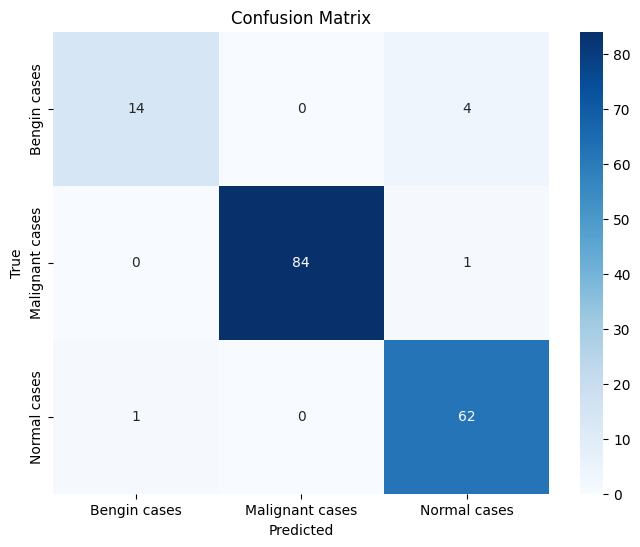

                 precision    recall  f1-score   support

   Bengin cases       0.93      0.78      0.85        18
Malignant cases       1.00      0.99      0.99        85
   Normal cases       0.93      0.98      0.95        63

       accuracy                           0.96       166
      macro avg       0.95      0.92      0.93       166
   weighted avg       0.96      0.96      0.96       166



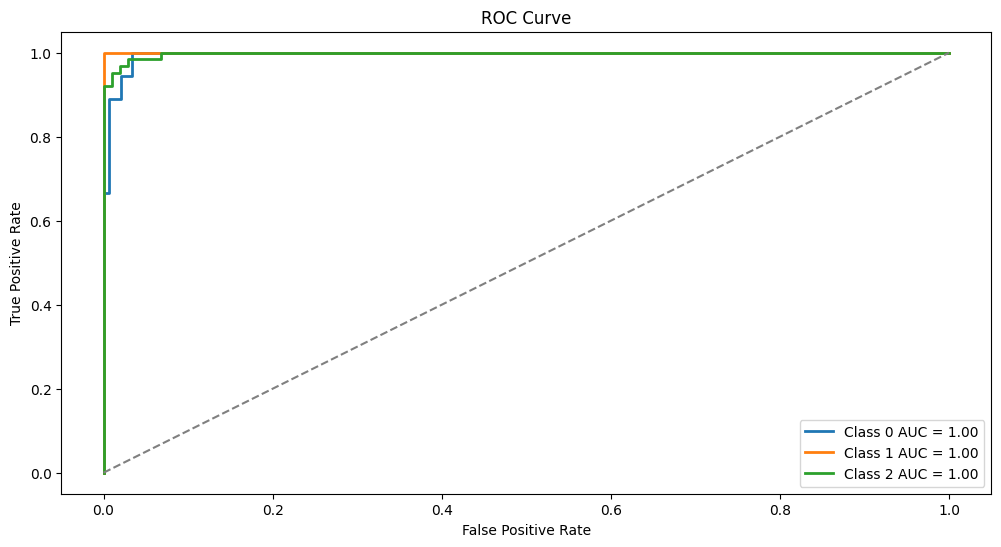

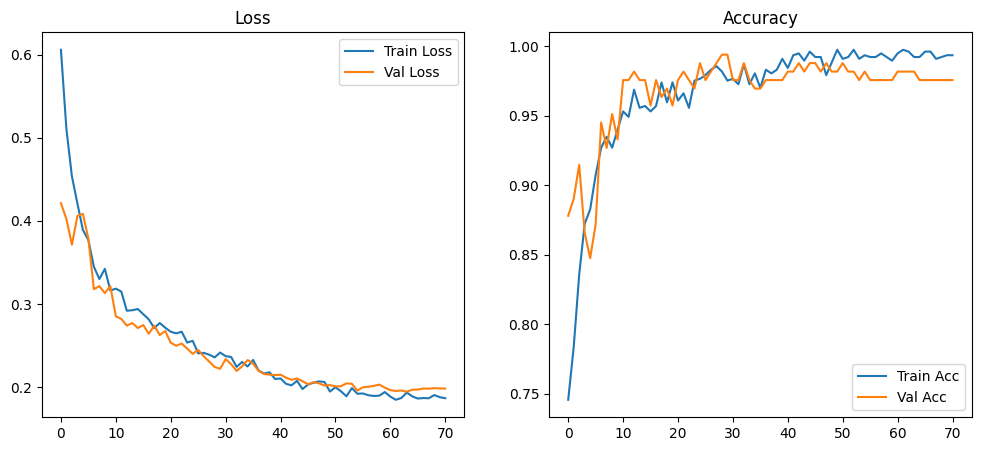

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.applications import ResNet152V2, InceptionV3
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Conv2D, Multiply, Activation, GlobalMaxPooling2D,
    Reshape, Add, Lambda, Input
)
from tensorflow.keras.regularizers import l2

# Custom Focal Loss for Multi-Class Classification
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# Custom HCSA Attention Block
def custom_attention_block(inputs, ratio=8):
    channel_avg = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // ratio, activation='relu')(channel_avg)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_out = Multiply()([inputs, Reshape((1, 1, -1))(dense_2)])
    spatial_out = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial_out])
    return spatial_out

# Dual Input Generator
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        return (x, x), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,  # Use same for both branches for simplicity
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Model Architecture
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze layers except the last 30
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in inception_base.layers[:-30]:
    layer.trainable = False

# Resize ResNet output to match Inception output (6x6)
resnet_resized = Lambda(
    lambda x: tf.image.resize(x, (6, 6)),
    output_shape=(6, 6, 2048)
)(resnet_base.output)

# Concatenate along channels
merged = Concatenate(axis=-1)([resnet_resized, inception_base.output])

# Apply HCSA Attention Block
attention_out = custom_attention_block(merged)
attention_out = Dropout(0.3)(attention_out)
gap = GlobalAveragePooling2D()(attention_out)

# Add fully connected layers
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)

# Final output layer
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, inception_base.input], outputs=output)

# Compile Model with Custom Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the Model
train_dual_input = DualInputGenerator(train_generator)
valid_dual_input = DualInputGenerator(valid_generator)

history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# Save the Model
model.save("hybrid_resnet_inception_hcsa_model.h5")

# ====== EVALUATION WITHOUT TTA STARTS HERE ======

# Prepare test input
test_dual_input = DualInputGenerator(test_generator)

# Model prediction (NO TTA)
y_pred_probs = model.predict(test_dual_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

# Model evaluation
test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss (no TTA): {test_loss}, Test Accuracy (no TTA): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

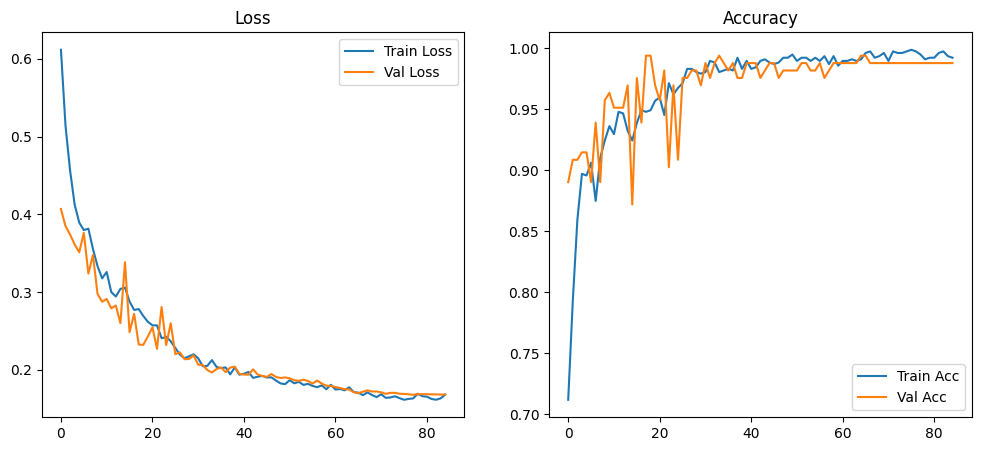

In [2]:
# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
[WARNING] Grad-CAM++ failed: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
[INFO] Falling back to Grad-CAM.


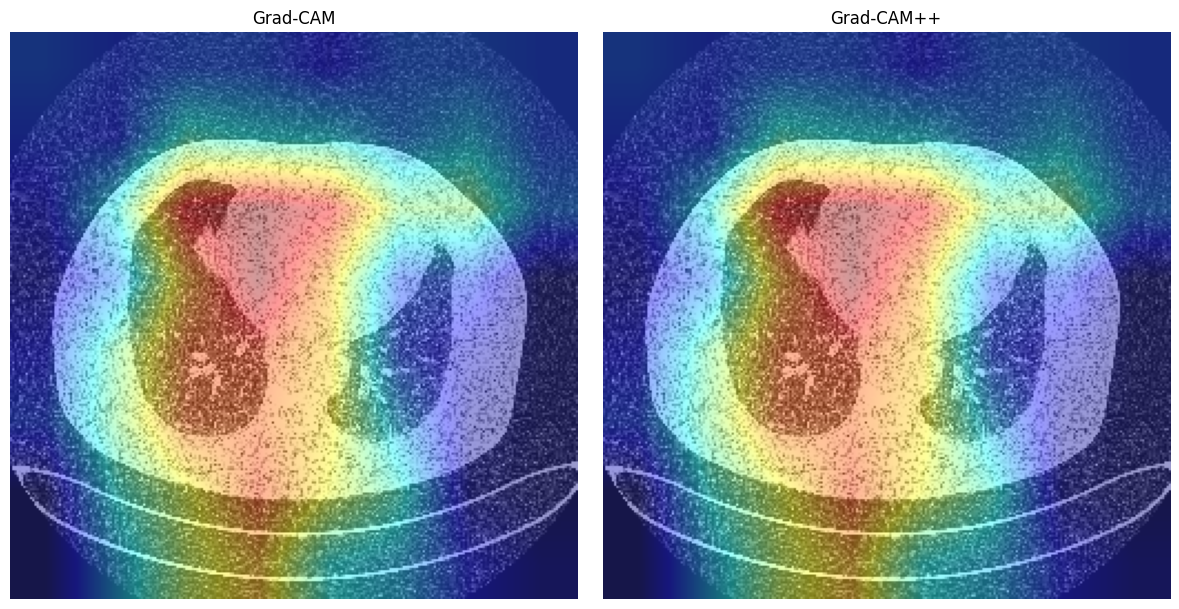

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import Model
import matplotlib.cm as cm

# ------------------------
# 🔧 Utility: Overlay heatmap
# ------------------------
def overlay_heatmap(heatmap, original_img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    color_map = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, color_map, alpha, 0)
    return superimposed_img

# ------------------------
# 🔧 Grad-CAM
# ------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ------------------------
# 🔧 Grad-CAM++
# ------------------------
def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    try:
        grads = tape.gradient(class_channel, conv_outputs)
        grads2 = tape.gradient(tf.reduce_sum(grads), conv_outputs)
        grads3 = tape.gradient(tf.reduce_sum(grads2), conv_outputs)

        if grads is None or grads2 is None or grads3 is None:
            raise ValueError("One or more gradients are None.")

        alpha_num = grads2
        alpha_denom = 2 * grads2 * grads2 + grads * grads3
        alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
        alphas = alpha_num / alpha_denom

        weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))
        heatmap = tf.reduce_sum(tf.nn.relu(weights[:, tf.newaxis, tf.newaxis, :] * conv_outputs), axis=-1)
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    except Exception as e:
        print(f"[WARNING] Grad-CAM++ failed: {e}")
        print("[INFO] Falling back to Grad-CAM.")
        return make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)


# ------------------------
# 📸 Choose and preprocess image from test set
# ------------------------
img_path = test_generator.filepaths[0]  # pick a sample image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = resnet_preprocess(img_array)  # use the same preprocessing as the model

# 🔁 Model expects two inputs (ResNet + Inception branches)
input_array = [img_array, img_array]

# ------------------------
# 🔍 Predict
# ------------------------
pred = model.predict(input_array)
pred_class = np.argmax(pred)

# ------------------------
# 🧠 Pick the correct last conv layer name
# ------------------------
# Use a layer from either ResNet or Inception
# You can use model.summary() to find layer names.
last_conv_layer_name = "conv5_block3_out"  # from ResNet152V2
# Or if you prefer InceptionV3, use something like:
# last_conv_layer_name = "mixed10"

# ------------------------
# 🔥 Generate heatmaps
# ------------------------
gradcam_heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name, pred_class)
gradcampp_heatmap = make_gradcampp_heatmap(input_array, model, last_conv_layer_name, pred_class)

# ------------------------
# 🖼 Overlay and display
# ------------------------
original_img_cv = cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR)

gradcam_img = overlay_heatmap(gradcam_heatmap, original_img_cv)
gradcampp_img = overlay_heatmap(gradcampp_heatmap, original_img_cv)

# ------------------------
# 📊 Plot
# ------------------------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(gradcam_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM++")
plt.imshow(cv2.cvtColor(gradcampp_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[WARNING] Grad-CAM++ failed: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
[INFO] Falling back to Grad-CAM.


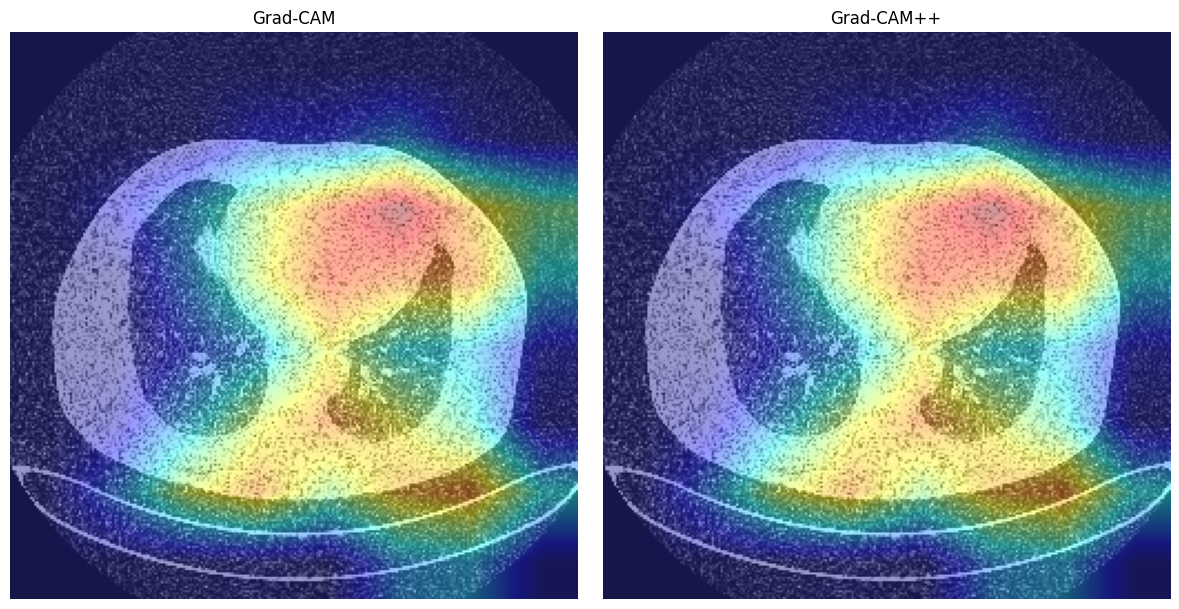

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import Model
import matplotlib.cm as cm

# ------------------------
# 🔧 Utility: Overlay heatmap
# ------------------------
def overlay_heatmap(heatmap, original_img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    color_map = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, color_map, alpha, 0)
    return superimposed_img

# ------------------------
# 🔧 Grad-CAM
# ------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ------------------------
# 🔧 Grad-CAM++
# ------------------------
def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    try:
        grads = tape.gradient(class_channel, conv_outputs)
        grads2 = tape.gradient(tf.reduce_sum(grads), conv_outputs)
        grads3 = tape.gradient(tf.reduce_sum(grads2), conv_outputs)

        if grads is None or grads2 is None or grads3 is None:
            raise ValueError("One or more gradients are None.")

        alpha_num = grads2
        alpha_denom = 2 * grads2 * grads2 + grads * grads3
        alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
        alphas = alpha_num / alpha_denom

        weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))
        heatmap = tf.reduce_sum(tf.nn.relu(weights[:, tf.newaxis, tf.newaxis, :] * conv_outputs), axis=-1)
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    except Exception as e:
        print(f"[WARNING] Grad-CAM++ failed: {e}")
        print("[INFO] Falling back to Grad-CAM.")
        return make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)


# ------------------------
# 📸 Choose and preprocess image from test set
# ------------------------
img_path = test_generator.filepaths[0]  # pick a sample image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = resnet_preprocess(img_array)  # use the same preprocessing as the model

# 🔁 Model expects two inputs (ResNet + Inception branches)
input_array = [img_array, img_array]

# ------------------------
# 🔍 Predict
# ------------------------
pred = model.predict(input_array)
pred_class = np.argmax(pred)

# ------------------------
# 🧠 Pick the correct last conv layer name
# ------------------------
# Use a layer from either ResNet or Inception
# You can use model.summary() to find layer names.
last_conv_layer_name = "conv5_block3_out"  # from ResNet152V2
# Or if you prefer InceptionV3, use something like:
# last_conv_layer_name = "mixed10"

# ------------------------
# 🔥 Generate heatmaps
# ------------------------
gradcam_heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name, pred_class)
gradcampp_heatmap = make_gradcampp_heatmap(input_array, model, last_conv_layer_name, pred_class)

# ------------------------
# 🖼 Overlay and display
# ------------------------
original_img_cv = cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR)

gradcam_img = overlay_heatmap(gradcam_heatmap, original_img_cv)
gradcampp_img = overlay_heatmap(gradcampp_heatmap, original_img_cv)

# ------------------------
# 📊 Plot
# ------------------------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(gradcam_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM++")
plt.imshow(cv2.cvtColor(gradcampp_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
print("Last conv layer:", last_conv_layer_name)

Last conv layer: conv2d_189


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract features from the penultimate layer
feature_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
features = feature_model.predict(test_dual_input)
labels = test_generator.classes

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Plot PCA
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(labels)):
    idx = labels == label
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=list(test_generator.class_indices.keys())[i], alpha=0.6)
plt.legend()
plt.title("Feature Visualization with PCA")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


In [12]:
pip install tf-keras-vis matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt

# Helper to preprocess and predict on a single image
def get_preprocessed_img(img_path, target_size=(256, 256)):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = resnet_preprocess(img_array)  # Use the same preprocess as your model
    return img_array

# Function to plot heatmap on image
def plot_gradcam(img_path, model, layer_name, pred_class_idx, method='gradcam'):
    img = get_preprocessed_img(img_path)
    replace2linear = ReplaceToLinear()
    score = CategoricalScore([pred_class_idx])
    # For dual input model, pass the same image to both inputs
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear

    # Choose Grad-CAM or Grad-CAM++
    if method == 'gradcam':
        gradcam = Gradcam(model, model_modifier=replace2linear)
    else:
        gradcam = GradcamPlusPlus(model, model_modifier=replace2linear)

    # Compute heatmap
    cam = gradcam(score, (img, img), penultimate_layer=layer_name)
    heatmap = cam[0]
    
    # Show result
    import cv2
    orig = cv2.imread(img_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, (256, 256))
    heatmap = cv2.resize(heatmap, (256, 256))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(orig)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title(f"{method} Heatmap")
    plt.imshow(heatmap)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title(f"Superimposed")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage for multiple images
img_paths = [
    '/kaggle/input/dataset/working/test/Malignant cases/Malignant case (128).jpg',
    '/kaggle/input/dataset/working/test/Malignant cases/Malignant case (178).jpg',
    '/kaggle/input/dataset/working/test/Malignant cases/Malignant case (171).jpg'
]
for img_path in img_paths:
    # Predict class
    img = get_preprocessed_img(img_path)
    preds = model.predict([img, img])
    pred_class_idx = np.argmax(preds[0])
    print(f"Predicted class: {pred_class_idx}")
    plot_gradcam(img_path, model, 'conv2d_189', pred_class_idx, method='gradcam')
    plot_gradcam(img_path, model, 'conv2d_189', pred_class_idx, method='gradcam++')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: 1


In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ✅ Create a feature extractor (from model, just before final Dense layer)
# 'drop' is your last dropout before final output layer
feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer(index=-2).output)


In [3]:
# Create test feature set using the same dual-input format
test_dual_input = DualInputGenerator(test_generator)

# Get true labels
true_labels = test_generator.classes

# Collect features for all test samples
features = feature_extractor.predict(test_dual_input)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step 


In [4]:
# Run t-SNE on extracted features
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_features = tsne.fit_transform(features)


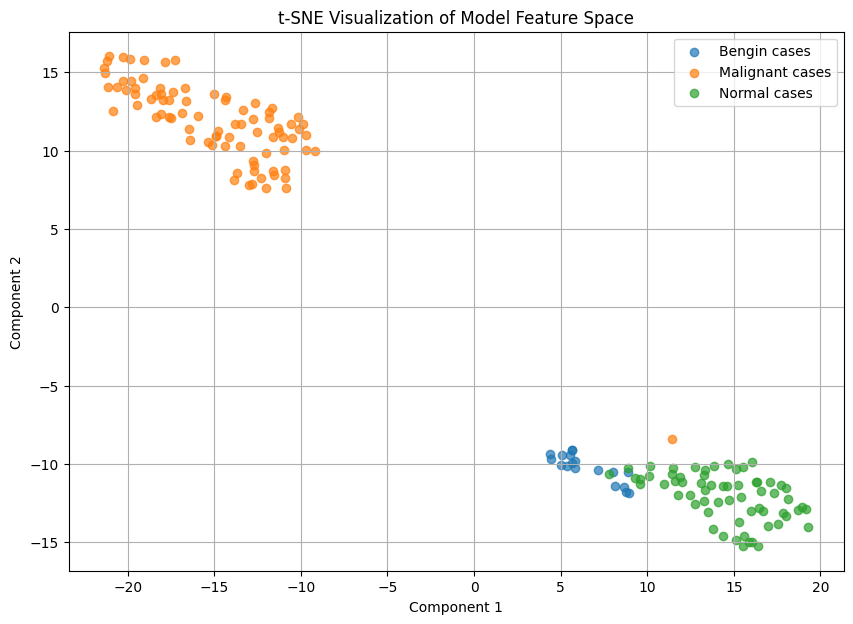

In [5]:
# Map label indices to class names
label_names = list(test_generator.class_indices.keys())
label_array = np.array([label_names[i] for i in true_labels])

# Plot
plt.figure(figsize=(10, 7))
for label in np.unique(label_array):
    idx = label_array == label
    plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], label=label, alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization of Model Feature Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


In [6]:
plt.savefig("tsne_visualization.png", dpi=300)


<Figure size 640x480 with 0 Axes>

2025-07-27 05:44:53.496619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753595093.837085      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753595093.934805      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 767 images belonging to 3 classes.
Found 164 images belonging to 3 classes.
Found 166 images belonging to 3 classes.
Class Weights: {0: 3.0436507936507935, 1: 0.6522108843537415, 2: 0.8785796105383734}


I0000 00:00:1753595113.412836      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753595113.413527      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 64, 64, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 64, 64, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 66, 66, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 63,234,214 (241.22 MB)

 Trainable params: 16,792,675 (64.06 MB)

 Non-trainable params: 46,441,539 (177.16 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1753595174.216654     118 service.cc:148] XLA service 0x7fc638004c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753595174.218520     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753595174.218541     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753595180.569914     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753595187.574194     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753595187.734204     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753595190.054476     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

33/48 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - accuracy: 0.5650 - loss: 0.6770

E0000 00:00:1753595224.874238     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753595225.032643     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753595227.152393     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753595227.292668     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.6028 - loss: 0.6591

E0000 00:00:1753595269.527232     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753595269.665607     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


48/48 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6046 - loss: 0.6581 - val_accuracy: 0.8110 - val_loss: 0.4626 - learning_rate: 1.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - accuracy: 0.7929 - loss: 0.5044 - val_accuracy: 0.9146 - val_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.8569 - loss: 0.4820 - val_accuracy: 0.9207 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 346ms/step - accuracy: 0.8847 - loss: 0.4276 - val_accuracy: 0.9085 - val_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - accuracy: 0.8979 - loss: 0.4259 - val_accuracy: 0.9634 - val_loss: 0.3315 - learning_rate: 1.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.9211 - loss: 0.3703 - val_accuracy: 0.9451 - val_loss: 0.3354 - learning_rate: 1.0000e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 

E0000 00:00:1753596462.980313     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753596463.122884     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 783ms/step - accuracy: 0.9492 - loss: 0.2315
Test Loss (no TTA): 0.21562880277633667, Test Accuracy (no TTA): 0.9698795080184937


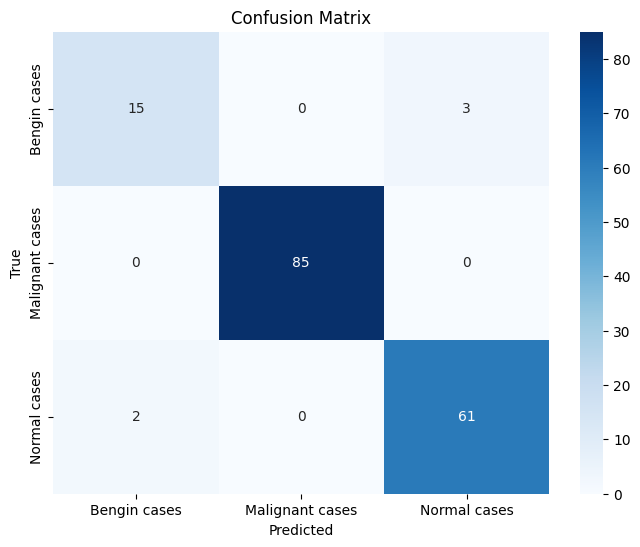

                 precision    recall  f1-score   support

   Bengin cases       0.88      0.83      0.86        18
Malignant cases       1.00      1.00      1.00        85
   Normal cases       0.95      0.97      0.96        63

       accuracy                           0.97       166
      macro avg       0.95      0.93      0.94       166
   weighted avg       0.97      0.97      0.97       166



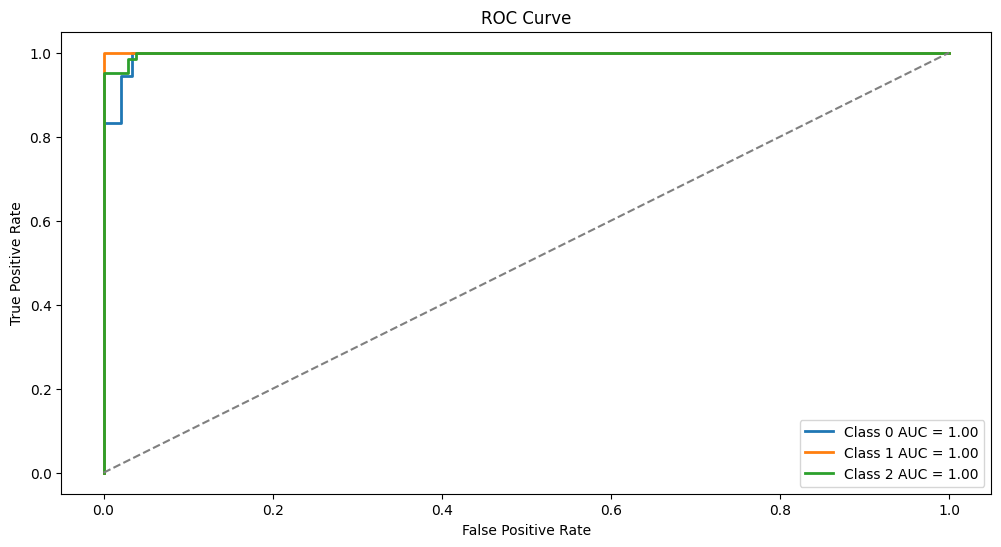

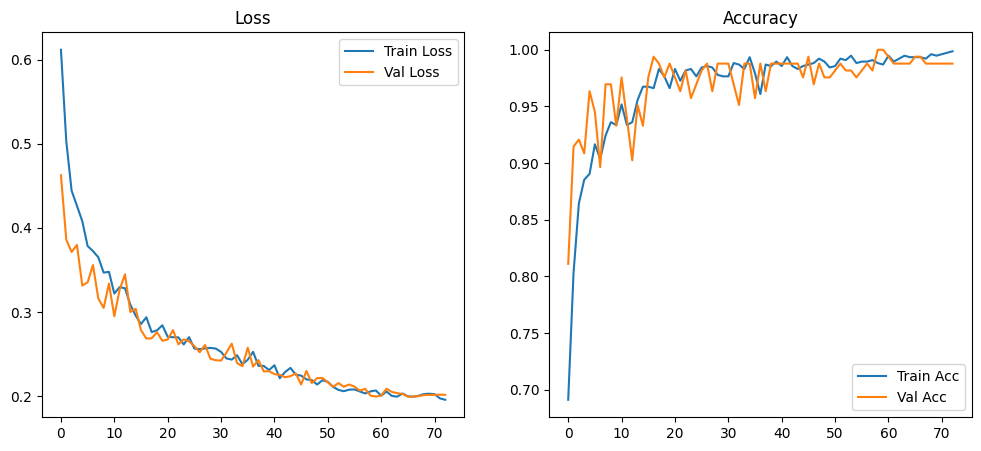

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

from tensorflow.keras.applications import ResNet152V2, EfficientNetB0
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Concatenate,
    Lambda, Input
)
from tensorflow.keras.regularizers import l2

# ========================
# Custom Focal Loss
def categorical_focal_loss(gamma=2.0):
    def focal_loss(y_true, y_pred):
        p = tf.nn.softmax(y_pred)
        ce = -y_true * tf.math.log(p + 1e-9)
        fl = (1 - p) ** gamma * ce
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss

# ========================
# Dual Input Generator to apply preprocessing to each branch
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, preprocess1, preprocess2):
        self.generator = generator
        self.preprocess1 = preprocess1
        self.preprocess2 = preprocess2

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]
        x1 = self.preprocess1(x.copy())
        x2 = self.preprocess2(x.copy())
        return (x1, x2), y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# ========================
# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=None,  # We'll preprocess in the generator
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=None)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/val',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    '/kaggle/input/dataset/working/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# ========================
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# ========================
# Model Architecture (No Attention)
resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
efficient_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze layers except the last 30 of each
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in efficient_base.layers[:-30]:
    layer.trainable = False

# Resize ResNet output to match EfficientNet output (8x8)
resnet_resized = Lambda(
    lambda x: tf.image.resize(x, (8, 8)),
    output_shape=(8, 8, 2048)
)(resnet_base.output)
# EfficientNetB0 output: (None, 8, 8, 1280)

# Concatenate along channels
merged = Concatenate(axis=-1)([resnet_resized, efficient_base.output])
# Shape: (None, 8, 8, 3328)

# Global Average Pooling and Dense Layers
gap = GlobalAveragePooling2D()(merged)
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(gap)
drop = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=[resnet_base.input, efficient_base.input], outputs=output)
model.summary()

# ========================
# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=categorical_focal_loss(gamma=2.0),
    metrics=['accuracy']
)

# ========================
# Prepare Dual Input Generators
train_dual_input = DualInputGenerator(train_generator, resnet_preprocess, efficient_preprocess)
valid_dual_input = DualInputGenerator(valid_generator, resnet_preprocess, efficient_preprocess)
test_dual_input  = DualInputGenerator(test_generator, resnet_preprocess, efficient_preprocess)

# ========================
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# ========================
# Train the Model
history = model.fit(
    train_dual_input,
    epochs=100,
    validation_data=valid_dual_input,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights_dict
)

# ========================
# Save the Model
model.save("hybrid_resnet_efficientnet_model.h5")

# ========================
# Evaluation
y_pred_probs = model.predict(test_dual_input)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_labels = test_generator.classes

test_loss, test_accuracy = model.evaluate(test_dual_input)
print(f"Test Loss (no TTA): {test_loss}, Test Accuracy (no TTA): {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
def plot_roc_curve(true_labels, predictions, num_classes):
    true_bin = tf.keras.utils.to_categorical(true_labels, num_classes=num_classes)
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, y_pred_probs, num_classes=3)

# Training History Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
correct_images = []
incorrect_images = []

for i in range(20):
    img, label = test_generator[i][0][0], test_generator[i][1][0]
    img_array = np.expand_dims(img, axis=0)
    pred = model.predict([img_array, img_array])
    true_class = np.argmax(label)
    pred_class = np.argmax(pred)

    if pred_class == true_class:
        correct_images.append((img, true_class, pred_class))
    else:
        incorrect_images.append((img, true_class, pred_class))

# Show Correctly Classified
for img, true_class, pred_class in correct_images:
    plt.imshow((img * 255).astype(np.uint8))
    plt.title(f"Correct - True: {true_class}, Pred: {pred_class}")
    plt.axis('off')
    plt.show()

# Show Misclassified
for img, true_class, pred_class in incorrect_images:
    plt.imshow((img * 255).astype(np.uint8))
    plt.title(f"Incorrect - True: {true_class}, Pred: {pred_class}")
    plt.axis('off')
    plt.show()


In [1]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
sample_images, sample_labels = next(train_generator)

# Show the first 6 images in the batch
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow((sample_images[i] + 1) / 2)  # Rescale if needed depending on preprocessing
    plt.title(f"Class: {list(train_generator.class_indices.keys())[np.argmax(sample_labels[i])]}")
    plt.axis('off')
plt.suptitle('Sample Images from Training Set')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NameError: name 'train_generator' is not defined